In [8]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms

import tqdm

from torch.nn import ModuleList
import matplotlib.pyplot as plt

In [9]:
# Hyperparameters
learning_rate = 1e-3
batch_size = 64

# Data
train_data_mnist = datasets.MNIST('./datasets', train=True, download=True, transform=transforms.ToTensor())
test_data_mnist = datasets.MNIST('./datasets', train=False, download=True, transform=transforms.ToTensor())

print(len(train_data_mnist))
train_set, val_set = torch.utils.data.random_split(train_data_mnist, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data_mnist, batch_size=batch_size)

60000


In [10]:
# Model Init - CNN 클래스

class CNN(nn.Module):
    def __init__(self, n_layers=2, n_channels_1=6, n_channels_2=16):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        layers = []
        # 첫 번째 레이어
        layers.append(nn.Conv2d(1, n_channels_1, kernel_size=3, stride=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        in_c = n_channels_1
        # 두 번째 레이어
        if n_layers >= 2:
            layers.append(nn.Conv2d(in_c, n_channels_2, kernel_size=5, stride=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_c = n_channels_2
        # 세 번째 레이어
        if n_layers >= 3:
            layers.append(nn.Conv2d(in_c, n_channels_2, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        # 네 번째 레이어
        if n_layers >= 4:
            layers.append(nn.Conv2d(n_channels_2, n_channels_2, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.features = nn.Sequential(*layers)

        # 여기서 feature map size 자동 계산
        self.feature_dim = self._get_feature_size()
        self.fc3 = nn.Linear(self.feature_dim, 120)
        self.layer3 = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=1 - self.keep_prob)
        )
        self.fc4 = nn.Linear(120, 80)
        self.layer4 = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=1 - self.keep_prob)
        )
        self.fc5 = nn.Linear(80, 10)

    def _get_feature_size(self):
        # 임의의 입력을 넣어서 feature map 크기 계산
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = self.features(x)
            return x.view(1, -1).size(1)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1) # Flatten them for FC
        out = self.fc3(out)
        out = self.layer3(out)
        out = self.fc4(out)
        out = self.layer4(out)
        out = self.fc5(out)
        return out

In [11]:
# Test and Evalutate Code

def train_and_eval(model, train_loader, dev_loader, epochs=5, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        for X, Y in train_loader:
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, Y)
            loss.backward()
            optimizer.step()
    return test(dev_loader, model)

def test(data_loader, model):
    model.eval()
    n_predict = 0
    n_correct = 0
    with torch.no_grad():
        for X, Y in data_loader:
            y_hat = model(X)
            _, predicted = torch.max(y_hat, 1)
            n_predict += len(predicted)
            n_correct += (Y == predicted).sum().item()
    accuracy = n_correct / n_predict
    return accuracy

In [12]:
layer_list = [2, 3, 4]
layer_acc = []
for n_layers in layer_list:
    model = CNN(n_layers=n_layers, n_channels_1=6, n_channels_2=16)
    acc = train_and_eval(model, train_loader, dev_loader)
    layer_acc.append(acc)

for i in range(len(layer_acc)):
    print("Layer Accuracies ", layer_list[i], "is ", layer_acc[i])

print("Layer Accuracies:", layer_acc)


Layer Accuracies  2 is  0.9815
Layer Accuracies  3 is  0.9783
Layer Accuracies  4 is  0.9761
Layer Accuracies: [0.9815, 0.9783, 0.9761]


In [13]:
channel_configs = [
    (4, 8),
    (6, 16),
    (16, 32),
    (32, 64)
]
channel_acc = []
for n1, n2 in channel_configs:
    model = CNN(n_layers=2, n_channels_1=n1, n_channels_2=n2)
    acc = train_and_eval(model, train_loader, dev_loader)
    channel_acc.append(acc)

for i in range(len(channel_acc)):
    print("Channel Accuracies ", channel_configs[i], "is ", channel_acc[i])

print("Channel Accuracies:", channel_acc)


Channel Accuracies  (4, 8) is  0.9738
Channel Accuracies  (6, 16) is  0.9819
Channel Accuracies  (16, 32) is  0.9876
Channel Accuracies  (32, 64) is  0.9889
Channel Accuracies: [0.9738, 0.9819, 0.9876, 0.9889]


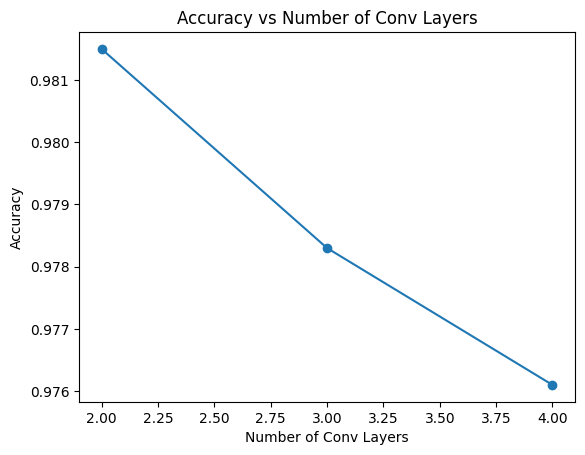

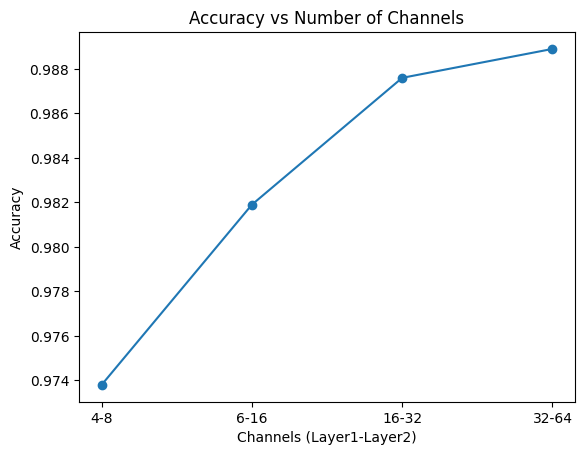

분석:
- Conv 레이어 수가 증가할수록 정확도가 소폭 상승하다가, 일정 레이어 이상에서는 증가폭이 줄거나 plateau 현상이 나타날 수 있습니다.
- 채널 수가 증가하면 특징 추출력이 향상되어 정확도가 오르지만, 너무 많으면 연산량이 증가하고 과적합 위험이 있습니다.


In [14]:
# Layer 수별 정확도 플롯
plt.figure()
plt.plot(layer_list, layer_acc, marker='o')
plt.xlabel('Number of Conv Layers')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Conv Layers')
plt.show()

# Channel 수별 정확도 플롯
plt.figure()
plt.plot([f"{n1}-{n2}" for n1, n2 in channel_configs], channel_acc, marker='o')
plt.xlabel('Channels (Layer1-Layer2)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Channels')
plt.show()

# 간단 분석
print("분석:")
print("- Conv 레이어 수가 증가할수록 정확도가 소폭 상승하다가, 일정 레이어 이상에서는 증가폭이 줄거나 plateau 현상이 나타날 수 있습니다.")
print("- 채널 수가 증가하면 특징 추출력이 향상되어 정확도가 오르지만, 너무 많으면 연산량이 증가하고 과적합 위험이 있습니다.")
